# The Ultimate Statistical Fighter

The aim of this project is to develop a segmentation of UFC fighters based on fight variables.
This project will also compare and contrast different clustering techniques to see 


Ultimately the goal will be to add fighting style labels and observe historical fights to observe behaviors in head to head matchups between fighter types.
    Cut across weight classes to observe differences between fighter matchups

In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.decomposition import PCA # Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Cleaning and Exploration

In [36]:
ufc = pd.read_csv('/kaggle/input/ultimate-ufc-dataset/ufc-master.csv')
print(ufc.head(5))
ufc.shape

          RedFighter        BlueFighter  RedOdds  BlueOdds  RedExpectedValue  \
0  Alexandre Pantoja        Kai Asakura   -250.0     215.0           40.0000   
1  Shavkat Rakhmonov  Ian Machado Garry   -210.0     295.0           47.6190   
2         Ciryl Gane   Alexander Volkov   -380.0     300.0           26.3158   
3     Bryce Mitchell        Kron Gracie   -950.0     625.0           10.5263   
4      Nate Landwehr         Dooho Choi   -130.0     110.0           76.9231   

   BlueExpectedValue        Date                Location Country Winner  ...  \
0              215.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
1              295.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
2              300.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
3              625.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
4              110.0  2024-12-07  Las Vegas, Nevada, USA     USA   Blue  ...   

      FinishDetails FinishRound Finish

(6528, 118)

In [37]:
# ufc.Winner.value_counts() # Unbalanced Dataset! Red wins much more frequently than Blue!

In [38]:
# len(set(ufc['BlueFighter'].unique()).union(set(ufc['RedFighter'].unique()))) # 2112 Unique fighters in dataset

In [39]:
# Look for problems in the dataset
blue_errors = ufc.loc[ufc['BlueWins']!= ufc['BlueWinsByTKODoctorStoppage'] 
+ ufc['BlueWinsByKO'] + ufc['BlueWinsByDecisionSplit'] + ufc['BlueWinsBySubmission'] 
+ ufc['BlueWinsByDecisionMajority'] + ufc['BlueWinsByDecisionUnanimous']]

red_errors = ufc.loc[ufc['RedWins']!= ufc['RedWinsByTKODoctorStoppage'] 
+ ufc['RedWinsByKO'] + ufc['RedWinsByDecisionSplit'] + ufc['RedWinsBySubmission'] 
+ ufc['RedWinsByDecisionMajority'] + ufc['RedWinsByDecisionUnanimous']]

blue_fighters_with_errors = blue_errors['BlueFighter'].unique()
red_fighters_with_errors = red_errors['RedFighter'].unique()

num_fighters_with_errors = len(set(blue_fighters_with_errors).union(set(red_fighters_with_errors)))

print(f'Number of fighters with errors in records: {num_fighters_with_errors}')

# Drop fighters with errors from the dataset
ufc_cleaned = ufc.drop(ufc[(ufc['BlueFighter'].isin(blue_fighters_with_errors)) | 
                           (ufc['RedFighter'].isin(red_fighters_with_errors))].index)

print(f'Dataset cleaned {len(ufc_cleaned)} rows remaining')

Number of fighters with errors in records: 122
Dataset cleaned 5649 rows remaining


In [40]:
# Combine Decisions
ufc_cleaned['RedWinsByDecision'] = ufc_cleaned['RedWinsByDecisionMajority'] + ufc_cleaned['RedWinsByDecisionSplit'] + ufc_cleaned['RedWinsByDecisionUnanimous']
ufc_cleaned['BlueWinsByDecision'] = ufc_cleaned['BlueWinsByDecisionMajority'] + ufc_cleaned['BlueWinsByDecisionSplit'] + ufc_cleaned['BlueWinsByDecisionUnanimous']

# Combine KO and TKO/Doctor Stoppage
ufc_cleaned['RedWinsByStrikes'] = ufc_cleaned['RedWinsByKO'] + ufc_cleaned['RedWinsByTKODoctorStoppage']
ufc_cleaned['BlueWinsByStrikes'] = ufc_cleaned['BlueWinsByKO'] + ufc_cleaned['BlueWinsByTKODoctorStoppage']

# Convert the 'Date' column to datetime format
ufc_cleaned["Date"] = pd.to_datetime(ufc_cleaned["Date"])

# Convert objects to category
ufc_cleaned[['WeightClass', 'RedStance', 'BlueStance']] = ufc_cleaned[['WeightClass', 'RedStance', 'BlueStance']].astype("category")

In [41]:
# Display weight class counts
print(ufc_cleaned['WeightClass'].value_counts())

# Filter out Catch Weight and Women's Featherweight due to small sample size
ufc_cleaned = ufc_cleaned.loc[~ufc_cleaned['WeightClass'].isin(['Catch Weight', "Women's Featherweight"])]

WeightClass
Lightweight              927
Welterweight             916
Middleweight             709
Featherweight            598
Bantamweight             588
Light Heavyweight        486
Heavyweight              377
Flyweight                331
Women's Strawweight      253
Women's Flyweight        201
Women's Bantamweight     188
Catch Weight              48
Women's Featherweight     27
Name: count, dtype: int64


In [42]:
# Keep only Relevant columns
cols_to_drop = ['RedOdds','BlueOdds','Gender','RedExpectedValue','BlueExpectedValue',
                'Location', 'Country', 'BlueWeightLbs','RedWeightLbs',
                'EmptyArena', 'FinishDetails', 'TitleBout', 'FinishDetails',
                'RedDecOdds','BlueDecOdds','RSubOdds','BSubOdds','RKOOdds',
                'BKOOdds'    
]

ufc_filtered = ufc_cleaned.drop(columns=cols_to_drop)

## Reshape the data from Fight-Level to Fighter-Level

In [43]:
# Select relevant fighter-level data
red_fighter_df = ufc_filtered.rename(columns={"RedFighter": "Fighter"}).drop(columns=[col for col in ufc_filtered.columns if "Blue" in col])
blue_fighter_df = ufc_filtered.rename(columns={"BlueFighter": "Fighter"}).drop(columns=[col for col in ufc_filtered.columns if "Red" in col])

# Standardize column names by removing "Red" and "Blue" prefixes
red_fighter_df.columns = [col.replace("Red", "") for col in red_fighter_df.columns]
blue_fighter_df.columns = [col.replace("Blue", "") for col in blue_fighter_df.columns]

# Combine datasets
fighter_df = pd.concat([red_fighter_df, blue_fighter_df])

# Drop duplicate columns that were merged (handling NaN issue)
fighter_df = fighter_df.loc[:, ~fighter_df.columns.duplicated()]

# Select the most recent fight for each fighter
fighter_latest_df = fighter_df.sort_values("Date", ascending=False).drop_duplicates(subset=["Fighter"], keep="first")

# Display final dataset
# print(fighter_latest_df.head())

### Condense to only relevant variables

In [44]:
# fighter_latest_df.columns

cols_to_keep = [
    'Fighter', 'WeightClass', 'Wins', 'Draws', 'Losses',
    'WinsByDecision', 'WinsByStrikes', 'WinsBySubmission', 
    'Stance', 'HeightCms', 'ReachCms', 'AvgSigStrLanded',
    'AvgSigStrPct', 'AvgSubAtt', 'AvgTDLanded', 'AvgTDPct',
    'TotalRoundsFought'
]

fighter_df = fighter_latest_df[cols_to_keep]

In [45]:
# Clean dataset
fighter_df['TotalBouts'] = fighter_df['Wins'] + fighter_df['Losses'] + fighter_df['Draws']

# fighter_df.Stance.value_counts() # Instances of incorrect values for stance

# Correcting incorrect stance values
fighter_df.loc[fighter_df.Fighter == "Nate Quarry", "Stance"] = "Orthodox"
fighter_df.loc[fighter_df.Fighter == "Krzysztof Soszynski", "Stance"] = "Southpaw"
fighter_df.loc[fighter_df.Fighter == "Juan Espino", "Stance"] = "Orthodox"

/tmp/ipykernel_67/1110801606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighter_df['TotalBouts'] = fighter_df['Wins'] + fighter_df['Losses'] + fighter_df['Draws']


In [46]:
# Calculate relative reach and relative height w.r.t weight class
weightclass_avgs = fighter_df[['HeightCms', 'ReachCms', 'WeightClass']].groupby(['WeightClass']).mean().reset_index()

# Merging the average height and reach per weight class
fighter_df = fighter_df.merge(weightclass_avgs, on="WeightClass", suffixes=("", "_Avg"))

# Calculate relative metrics
fighter_df['RelativeHeight'] = fighter_df['HeightCms'] / fighter_df['HeightCms_Avg']
fighter_df['RelativeReach'] = fighter_df['ReachCms'] / fighter_df['ReachCms_Avg']

print(fighter_df.head())

             Fighter   WeightClass  Wins  Draws  Losses  WinsByDecision  \
0  Alexandre Pantoja     Flyweight    12      0       3               6   
1  Shavkat Rakhmonov  Welterweight     6      0       0               0   
2     Lukasz Brzeski   Heavyweight     2      0       4               1   
3       Chase Hooper   Lightweight     7      0       3               2   
4        Max Griffin  Welterweight     8      0       8               5   

   WinsByStrikes  WinsBySubmission    Stance  HeightCms  ...  AvgSigStrPct  \
0              2                 4  Orthodox     165.10  ...          0.49   
1              1                 5  Orthodox     185.42  ...          0.61   
2              0                 1  Orthodox     193.04  ...          0.50   
3              2                 3  Southpaw     185.42  ...          0.52   
4              3                 0  Orthodox     180.34  ...          0.49   

   AvgSubAtt  AvgTDLanded  AvgTDPct  TotalRoundsFought  TotalBouts  \
0        0

/tmp/ipykernel_67/1726737644.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weightclass_avgs = fighter_df[['HeightCms', 'ReachCms', 'WeightClass']].groupby(['WeightClass']).mean().reset_index()


In [47]:
# Check for other errors in dataset
fighter_df.query('TotalBouts > TotalRoundsFought') # Drop instances of incorrect values

fighter_df = fighter_df.loc[fighter_df['TotalBouts'] <= fighter_df['TotalRoundsFought']]

# fighter_df.loc[fighter_df['Wins'] != fighter_df['WinsByDecision'] + fighter_df['WinsByStrikes'] + fighter_df['WinsBySubmission'] ] # No errors

In [48]:
fighter_df.isna().sum()

fighter_df = fighter_df.dropna(subset = ['AvgSigStrLanded', 'AvgSigStrPct', 'AvgSubAtt', 'AvgTDLanded' , 'AvgTDPct'])

### Create more fighter variables

In [49]:
# Create TD Attempted variable: 1 / (TD Percentage * TD Landed)  
fighter_df['TDAttempts'] = 1/ (fighter_df['AvgTDPct'] * fighter_df['AvgTDLanded'])

# Create wins by type as a percentage of all wins
fighter_df['WinsBySubmissionPct'] = fighter_df['WinsBySubmission'] / fighter_df['Wins']
fighter_df['WinsByStrikesPct'] = fighter_df['WinsByStrikes'] / fighter_df['Wins']
fighter_df['WinsByDecisionPct'] = fighter_df['WinsByDecision'] / fighter_df['Wins']

# Replace NaNs with 0 where Wins are 0
fighter_df.fillna({'WinsBySubmissionPct': 0,
                   'WinsByStrikesPct': 0,
                   'WinsByDecisionPct': 0,
                  'TDAttempts': 0}, inplace=True)


### Check distributions of segmentation variables

In [50]:
# Convert infinite values to NaN
fighter_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure changes are applied
print("Fixed infinite values:", fighter_df.isin([np.inf, -np.inf]).sum().sum())  # Should print 0

Fixed infinite values: 0


In [51]:
# Filter out fighters with less than 5 fights

fighter_df = fighter_df.query('TotalBouts > 4')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

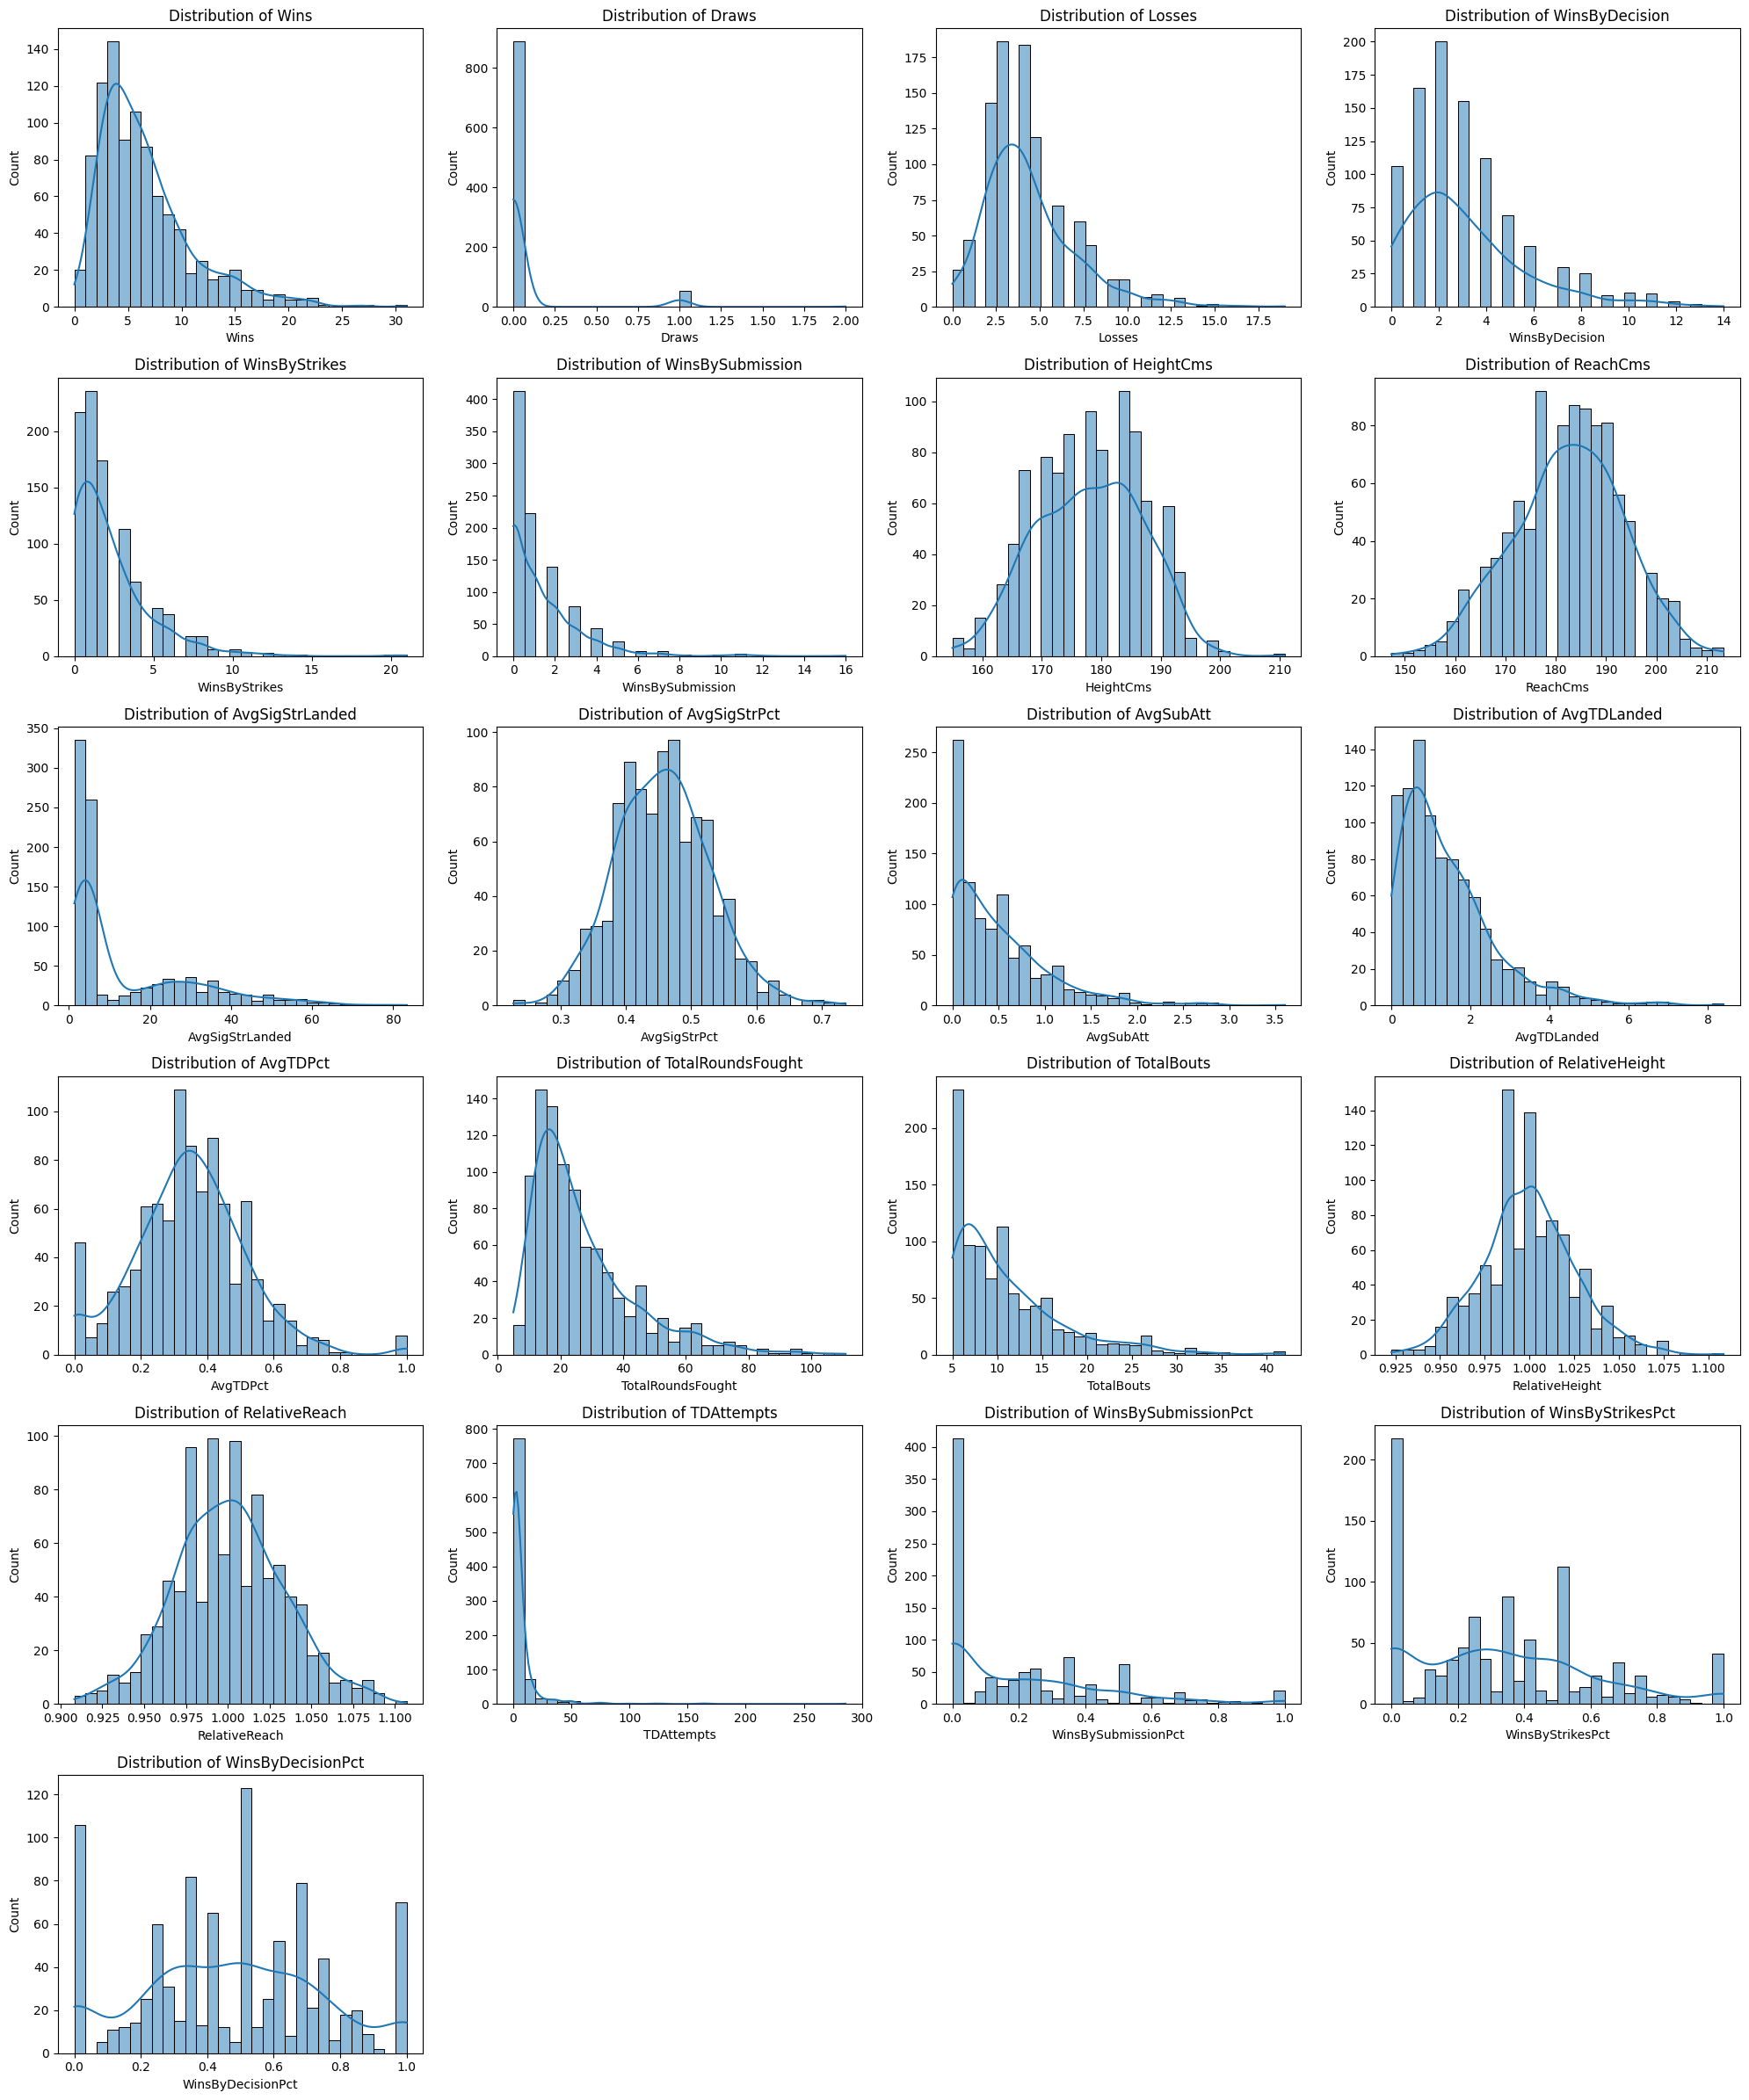

In [52]:
# Identify numerical columns
numeric_columns = ['Wins', 'Draws', 'Losses', 'WinsByDecision', 'WinsByStrikes', 'WinsBySubmission',
                   'HeightCms', 'ReachCms', 'AvgSigStrLanded', 'AvgSigStrPct', 'AvgSubAtt', 'AvgTDLanded',
                   'AvgTDPct', 'TotalRoundsFought', 'TotalBouts',
                   'RelativeHeight', 'RelativeReach', 'TDAttempts', 'WinsBySubmissionPct',
                   'WinsByStrikesPct', 'WinsByDecisionPct']

# Set up the grid for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)  # Creates a grid with up to 4 plots per row

fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numeric_columns):
    sns.histplot(fighter_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

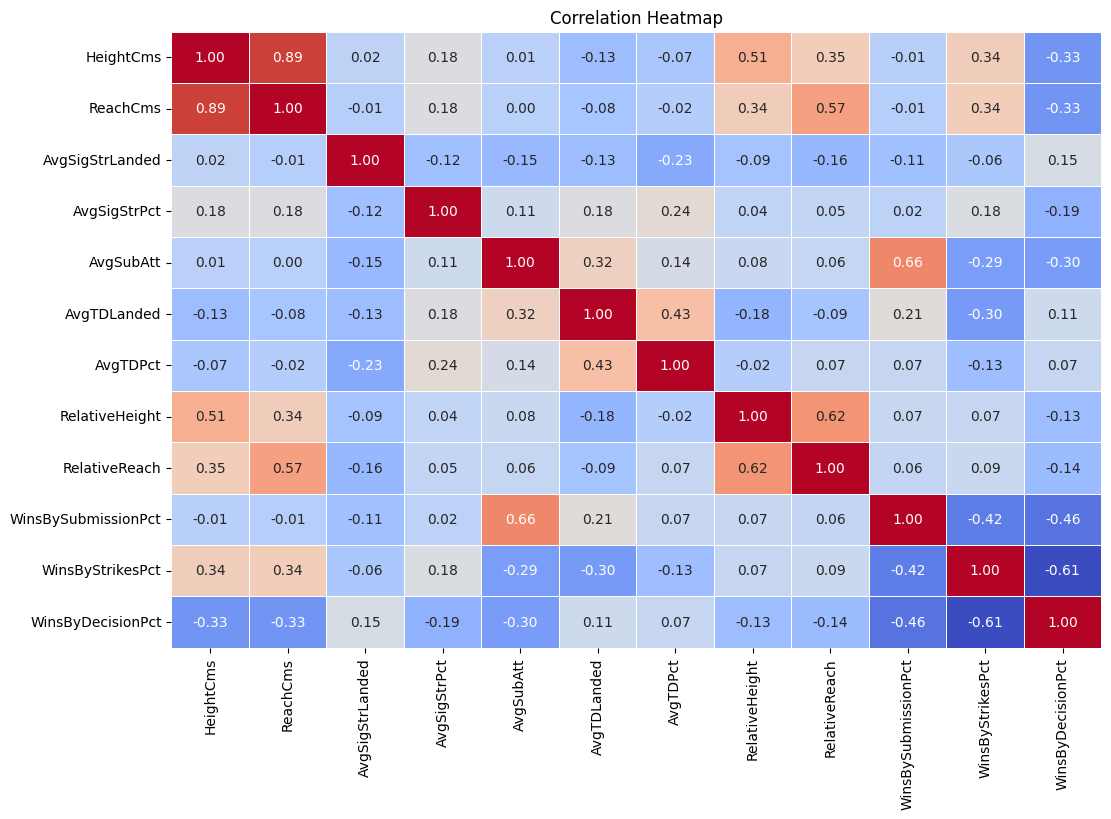

In [53]:
# Exploratory Graphs

# Heatmap
corr_columns = ['HeightCms', 'ReachCms', 'AvgSigStrLanded', 'AvgSigStrPct', 'AvgSubAtt', 'AvgTDLanded',
                   'AvgTDPct','RelativeHeight', 'RelativeReach', 'WinsBySubmissionPct',
                   'WinsByStrikesPct', 'WinsByDecisionPct']

# Compute correlation matrix
corr_matrix = fighter_df[corr_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar = False)

plt.title('Correlation Heatmap')
plt.show()

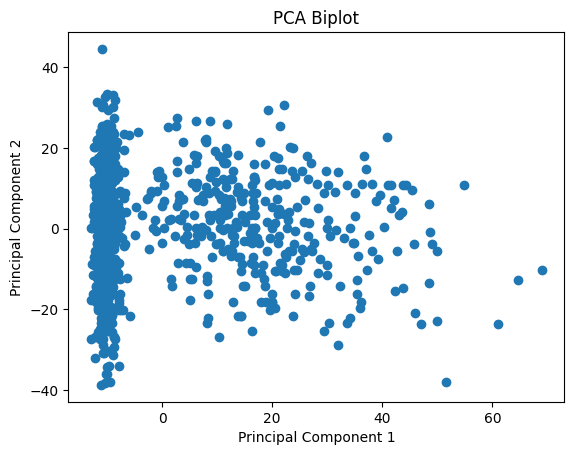

In [54]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(fighter_df[corr_columns])

plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

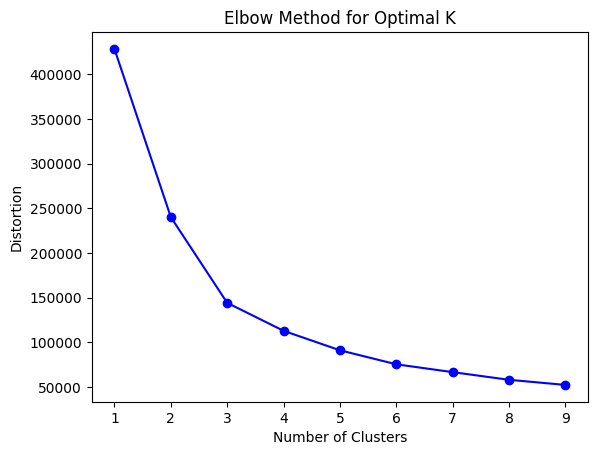

In [55]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(fighter_df[corr_columns])
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

For K Means segmentation number of clusters lies betwen 3 and 4

In order to segment fighters need to change the data structure from 

Will focus on the fighting variables for segmentation including
* Decision vs. KO vs. Submission
* AvgSigStrLanded
* AvgSigStrPct
* AvgSubAtt
* AvgTDLanded
* AvgTDPct
* Stance
* Height relative to weight class
* Reach relative to weight class
* Country/Region?

## Begin Segmentation

In [56]:
# Clustering Variables
cluster_cols = ['AvgSigStrLanded', 'AvgSigStrPct', 'AvgSubAtt',
    'WinsBySubmissionPct','WinsByStrikesPct', 'WinsByDecisionPct']

# Select numerical features for clustering
X = fighter_df[cluster_cols]  # Using selected features for segmentation

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
fighter_df['Cluster_Kmeans'] = kmeans.fit_predict(X_scaled)

In [57]:
# Compute cohesion metric (Silhouette Score)
sil_score = silhouette_score(X_scaled, fighter_df['Cluster_Kmeans'])
print(f'Silhouette Score: {sil_score:.3f}')  # Closer to 1 means better-defined clusters

# Check cluster sizes
print(fighter_df['Cluster_Kmeans'].value_counts())

# Compute within-cluster variance (WCSS)
print(f'Within-Cluster Sum of Squares: {kmeans.inertia_:.3f}')

Silhouette Score: 0.248
Cluster_Kmeans
2    304
3    249
1    223
0    169
Name: count, dtype: int64
Within-Cluster Sum of Squares: 2826.535


With silouhette scores of ~.25, it is an acceptable clustering and can serive as a baseline to compare other clustering methods.

In [58]:
# Compute average values for numeric columns per cluster
cluster_summary = fighter_df.select_dtypes(include=['number']).groupby('Cluster_Kmeans').mean()
cluster_summary[corr_columns]

,HeightCms,ReachCms,AvgSigStrLanded,AvgSigStrPct,AvgSubAtt,AvgTDLanded,AvgTDPct,RelativeHeight,RelativeReach,WinsBySubmissionPct,WinsByStrikesPct,WinsByDecisionPct
Cluster_Kmeans,,,,,,,,,,,,
0,177.063550,180.835976,40.240473,0.420929,0.345579,1.365607,0.294225,0.994166,0.991056,0.099006,0.21526,0.679817
1,178.096143,182.447175,9.359059,0.459278,1.156038,1.823128,0.363830,1.004333,1.005071,0.541983,0.18105,0.276967
2,175.101250,179.437632,4.639863,0.451342,0.283591,1.487901,0.383375,0.998686,1.001852,0.095183,0.22239,0.682427
3,182.155743,187.541767,12.566381,0.486129,0.288092,0.942712,0.327181,1.000622,1.003128,0.091583,0.67707,0.231347


In [59]:
# Look at some examples of each kind of fighter to better inform our labeling

for cluster in range(fighter_df['Cluster_Kmeans'].nunique()):
    print('Fighters with most fights in cluster', cluster)

    # Filter first, then sort by 'TotalBouts', then get top 5
    top_fighters = fighter_df.loc[fighter_df['Cluster_Kmeans'] == cluster].sort_values(by='TotalBouts', ascending=False).head(5)

    print(top_fighters[['Fighter', 'TotalBouts']])  # Display relevant columns

Fighters with most fights in cluster 0
              Fighter  TotalBouts
1327  Michael Bisping          28
1281    Gleison Tibau          27
1339    Diego Sanchez          26
1170     Ross Pearson          25
1157     Thiago Alves          25
Fighters with most fights in cluster 1
               Fighter  TotalBouts
486         Jim Miller          42
58    Charles Oliveira          32
925        Demian Maia          32
1025   Fabricio Werdum          31
432     Dustin Poirier          31
Fighters with most fights in cluster 2
              Fighter  TotalBouts
15         Clay Guida          39
131  Rafael Dos Anjos          35
68         Neil Magny          33
911   Jeremy Stephens          32
341        King Green          30
Fighters with most fights in cluster 3
                Fighter  TotalBouts
987      Anderson Silva          41
731        Mauricio Rua          41
666       Robbie Lawler          35
188  Ovince Saint Preux          34
125        Max Holloway          29


With 4 clusters there are distinct differences in observable fight variables.

0. Volume Strikers
- High significant strikes landed (40.24), meaning this group relies heavily on volume striking.
- Low submission attempts and takedown accuracy, reinforcing their stand-up heavy style.
- Most wins come from decision (67.9%), indicating a pace-heavy approach rather than finishing power

1. Submission Specialist
- High submission attempts (1.16) and relatively high takedown volume (1.82).
- Lower striking volume, meaning they likely look for grappling-heavy strategies.
- High submission win rate (54.2%), confirming their submission-oriented approach.

2. Balanced Grappler
- Moderate submission attempts (0.28) and takedown volume (1.48).
- Moderate striking volume, suggesting a well-rounded style.
- Win distribution is similar to Cluster 0 (majority decisions, some striking finishes)

3. Precision Strikers
- High significant strike accuracy (48.6%), meaning they land clean, effective shots.
- High wins by strikes (67.7%), confirming their KO-heavy finishing ability.
- Taller and longer reach than the other groups, which may aid their striking dominance.


In [60]:
# Define cluster name mappings
cluster_names = {
    0: "Volume Striker",
    1: "Submission Specialist",
    2: "Balanced Grappler",
    3: "Precision Striker"
}

# Apply names to the dataset
fighter_df['FightingStyle'] = fighter_df['Cluster_Kmeans'].map(cluster_names)

# Display updated DataFrame
print(fighter_df[['Fighter', 'Cluster_Kmeans', 'FightingStyle']].head())


             Fighter  Cluster_Kmeans          FightingStyle
0  Alexandre Pantoja               1  Submission Specialist
1  Shavkat Rakhmonov               1  Submission Specialist
2     Lukasz Brzeski               1  Submission Specialist
3       Chase Hooper               1  Submission Specialist
4        Max Griffin               2      Balanced Grappler


With an expected cluster size between 3-4, use alternative algorithm which has good use case for lower cluster size

### Clustering method 2

Silhouette Score for Spectral Clustering: 0.18761582333903784


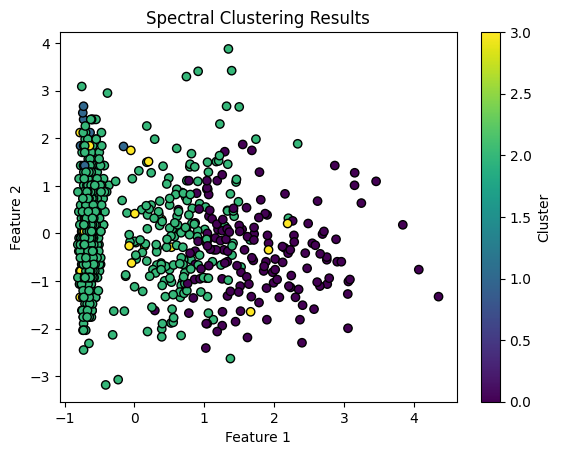

In [61]:
from sklearn.cluster import SpectralClustering
# Standardize features for better clustering performance
scaler = StandardScaler()
fighter_scaled = scaler.fit_transform(fighter_df[cluster_cols])

# Define number of clusters based on prior insights (e.g., 3-4)
num_clusters = 4

# Apply Spectral Clustering
spectral_cluster = SpectralClustering(n_clusters=num_clusters, affinity='rbf', assign_labels='discretize', random_state=42)
fighter_df['Cluster_Spectral'] = spectral_cluster.fit_predict(fighter_scaled)

# Compute silhouette score to evaluate cluster quality
silhouette_avg = silhouette_score(fighter_scaled, fighter_df['Cluster_Spectral'])
print(f"Silhouette Score for Spectral Clustering: {silhouette_avg}")

# Visualize clusters (optional, using first two principal components)
plt.scatter(fighter_scaled[:, 0], fighter_scaled[:, 1], c=fighter_df['Cluster_Spectral'],
            cmap='viridis', edgecolors='k')
plt.title("Spectral Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()

In this instance, Spectral Clustering not performing better than traditional K-Means clustering. Try a soft clustering technique instead.

In [62]:
# Select only relevant clustering columns
cluster_cols = ['AvgSigStrLanded', 'AvgSigStrPct', 'AvgSubAtt',
    'WinsBySubmissionPct','WinsByStrikesPct', 'WinsByDecisionPct']

# Standardize the selected features
scaler = StandardScaler()
fighter_scaled = scaler.fit_transform(fighter_df[cluster_cols])

# Define number of clusters (3-4 based on previous analysis)
num_clusters = 4

# Apply Gaussian Mixture Model only on selected columns
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
fighter_df['Cluster_GMM'] = gmm.fit_predict(fighter_scaled)

# Compute silhouette score for clustering evaluation
silhouette_avg = silhouette_score(fighter_scaled, fighter_df['Cluster_GMM'])
print(f"Silhouette Score for GMM Clustering: {silhouette_avg}")

Silhouette Score for GMM Clustering: 0.08670375856598908


### Check head to head win % across the different fighting styles

In [63]:
ufc_filtered.Winner.value_counts() 

Red_winrate = round(3229 / (2345 + 3229), 2)
Blue_winrate = round(2345 / (2345 + 3229), 2)

print('Red_winrate:', Red_winrate)
print('Blue_winrate:', Blue_winrate)

# Unbalanced overall winrates w.r.t corner

Red_winrate: 0.58
Blue_winrate: 0.42


In [64]:
# Merge fighter clusters onto Red Fighters
ufc_filtered = ufc_filtered.merge(fighter_df[['Fighter', 'Cluster_Kmeans', 'FightingStyle']], 
                                      left_on='RedFighter', right_on='Fighter', how='left').rename(
                                      columns={'Cluster_Kmeans': 'Red_Cluster_Kmeans',
                                              'FightingStyle': 'Red_FightingStyle'}).drop(columns=['Fighter'])

# Merge fighter clusters onto Blue Fighters
ufc_filtered = ufc_filtered.merge(fighter_df[['Fighter', 'Cluster_Kmeans','FightingStyle']], 
                                      left_on='BlueFighter', right_on='Fighter', how='left').rename(
                                      columns={'Cluster_Kmeans': 'Blue_Cluster_Kmeans',
                                              'FightingStyle': 'Blue_FightingStyle'}).drop(columns=['Fighter'])

# Drop NaNs to clean data
ufc_filtered_clean = ufc_filtered.dropna(subset=['Red_FightingStyle', 'Blue_FightingStyle', 'Winner'])

In [65]:
# Create matchup tuples (always sorted to ensure consistency)
ufc_filtered_clean['Matchup'] = ufc_filtered_clean.apply(lambda x: tuple(sorted([x['Red_FightingStyle'], x['Blue_FightingStyle']])), axis=1)

# Create a new column 'Winning_FightingStyle' based on the winner's corner
ufc_filtered_clean['Winning_FightingStyle'] = ufc_filtered_clean.apply(lambda x: x['Red_FightingStyle'] if x['Winner'] == 'Red' else x['Blue_FightingStyle'], axis=1)

# Display first few rows to verify the results
print(ufc_filtered_clean[['Winner', 'Red_FightingStyle', 'Blue_FightingStyle', 'Winning_FightingStyle', 'Matchup']].head())

  Winner      Red_FightingStyle Blue_FightingStyle  Winning_FightingStyle  \
1    Red  Submission Specialist  Balanced Grappler  Submission Specialist   
2    Red      Precision Striker  Precision Striker      Precision Striker   
4    Red      Precision Striker  Precision Striker      Precision Striker   
5    Red      Precision Striker  Balanced Grappler      Precision Striker   
6   Blue      Balanced Grappler  Precision Striker      Precision Striker   

                                      Matchup  
1  (Balanced Grappler, Submission Specialist)  
2      (Precision Striker, Precision Striker)  
4      (Precision Striker, Precision Striker)  
5      (Balanced Grappler, Precision Striker)  
6      (Balanced Grappler, Precision Striker)  


/tmp/ipykernel_67/1711351879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_filtered_clean['Matchup'] = ufc_filtered_clean.apply(lambda x: tuple(sorted([x['Red_FightingStyle'], x['Blue_FightingStyle']])), axis=1)
/tmp/ipykernel_67/1711351879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_filtered_clean['Winning_FightingStyle'] = ufc_filtered_clean.apply(lambda x: x['Red_FightingStyle'] if x['Winner'] == 'Red' else x['Blue_FightingStyle'], axis=1)


In [66]:
# Compute stylistic matchup win rates
matchup_win_rates = ufc_filtered_clean.groupby(['Matchup', 'Winning_FightingStyle']).size().unstack(fill_value=0)

# Normalize to get percentage win rates
matchup_win_rates = matchup_win_rates.div(matchup_win_rates.sum(axis=1), axis=0)

rows_to_drop = [
    ('Balanced Grappler', 'Balanced Grappler'),
    ('Precision Striker', 'Precision Striker'),
    ('Submission Specialist', 'Submission Specialist'),
    ('Volume Striker', 'Volume Striker')
]

# Drop redundant rows 
matchup_win_rates_fixed  = matchup_win_rates.drop(rows_to_drop, axis=0)

matchup_win_rates_fixed

Winning_FightingStyle,Balanced Grappler,Precision Striker,Submission Specialist,Volume Striker
Matchup,,,,
"(Balanced Grappler, Precision Striker)",0.506931,0.493069,0.000000,0.000000
"(Balanced Grappler, Submission Specialist)",0.554435,0.000000,0.445565,0.000000
"(Balanced Grappler, Volume Striker)",0.656388,0.000000,0.000000,0.343612
"(Precision Striker, Submission Specialist)",0.000000,0.508824,0.491176,0.000000
"(Precision Striker, Volume Striker)",0.000000,0.552764,0.000000,0.447236
"(Submission Specialist, Volume Striker)",0.000000,0.000000,0.597285,0.402715


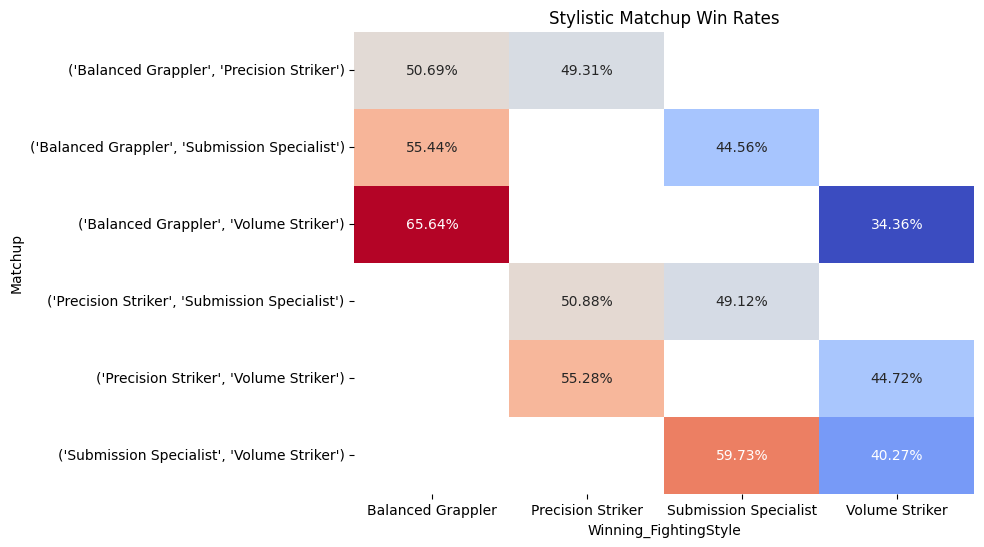

In [67]:
# Make heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(
    matchup_win_rates_fixed, 
    cmap="coolwarm", 
    cbar=False, 
    annot=True, 
    fmt=".2%",  # Formats annotations as percentages with 2 decimal places
    mask=(matchup_win_rates_fixed == 0)  # Excludes zeros from colormap
)

plt.title("Stylistic Matchup Win Rates")
plt.show()

### Calculate matchup winrates across weightclasses

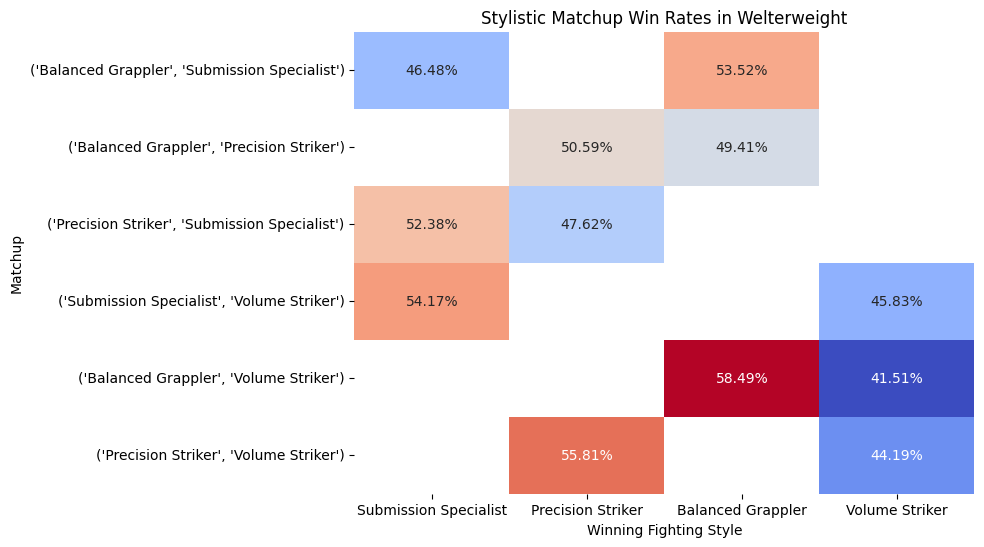

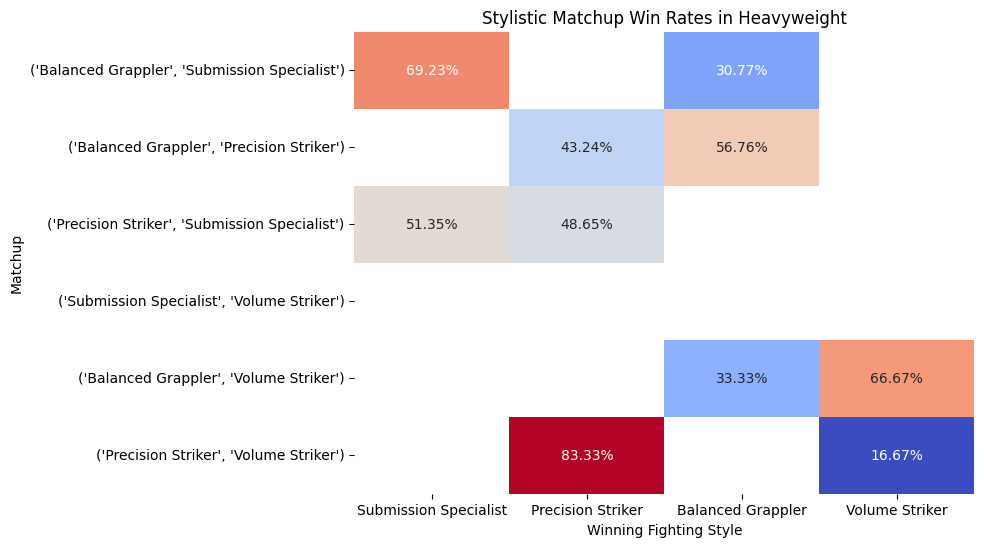

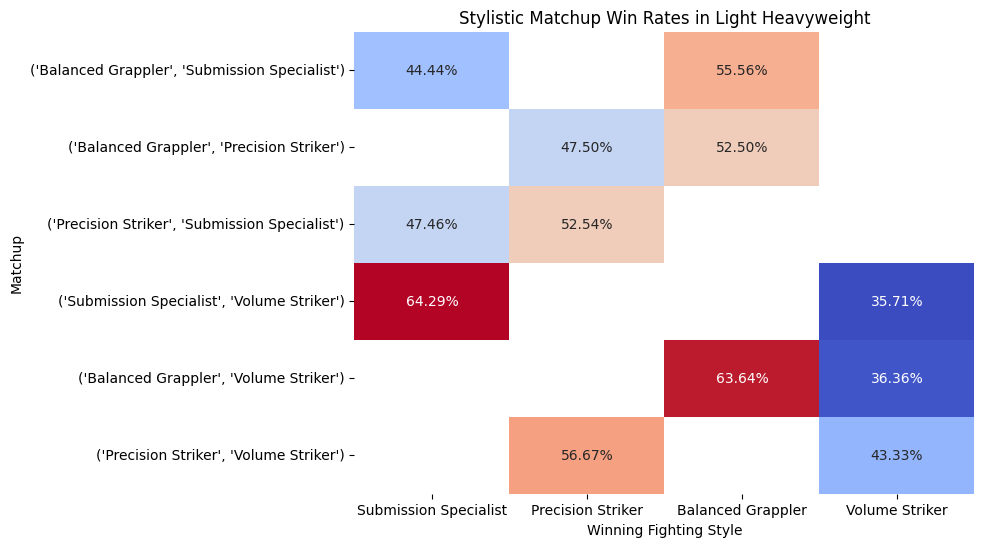

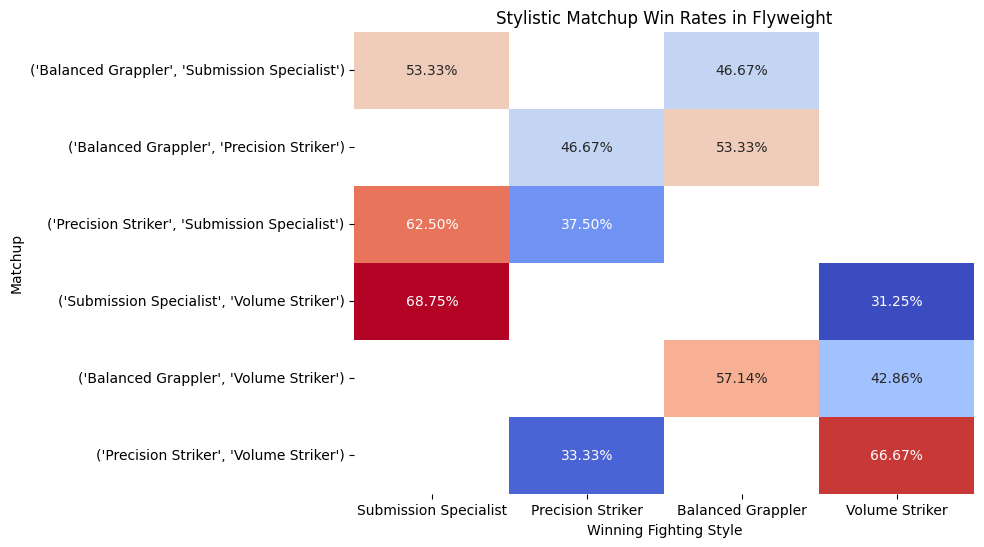

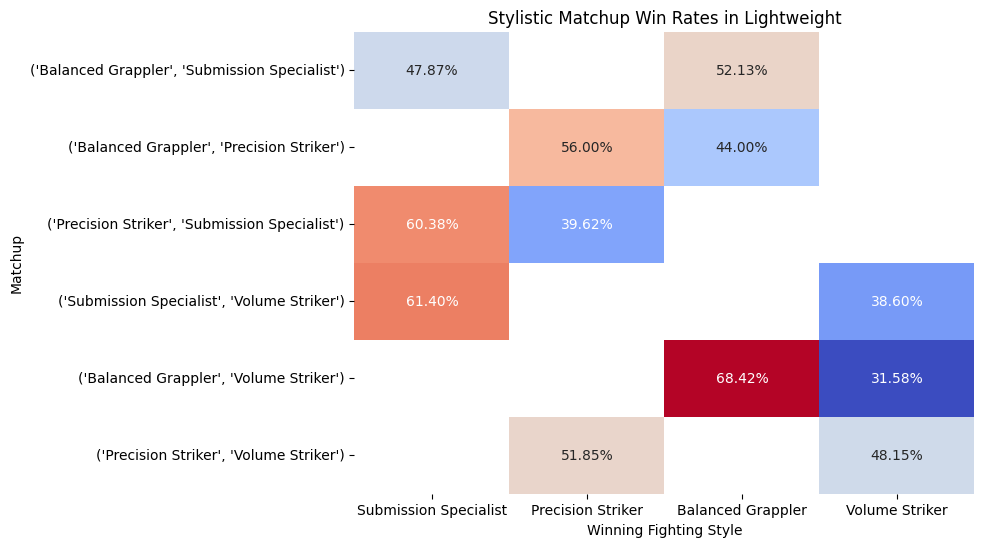

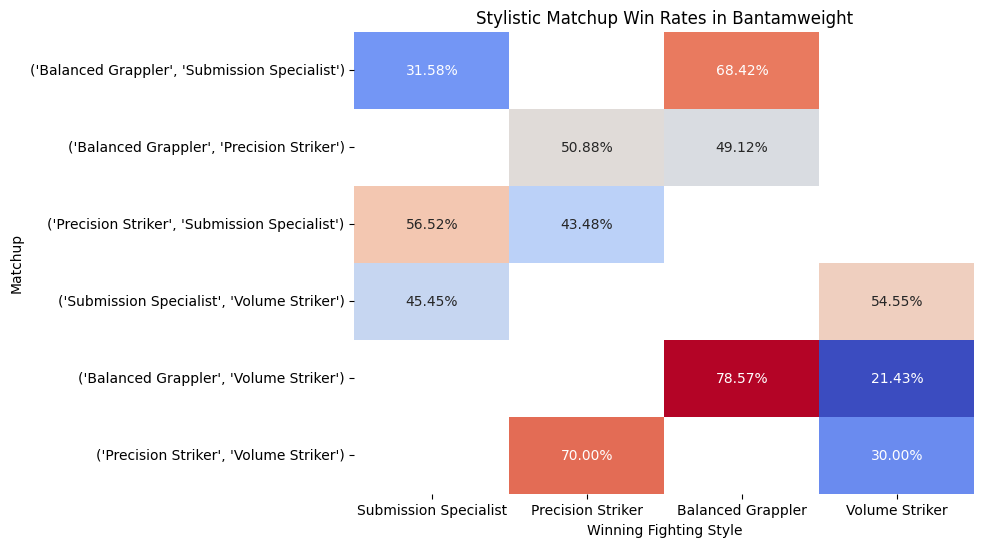

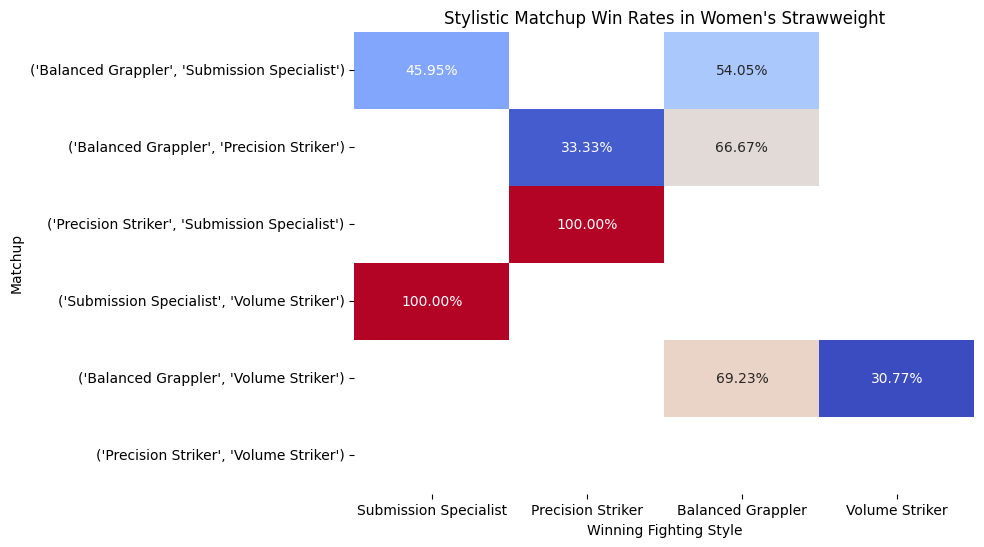

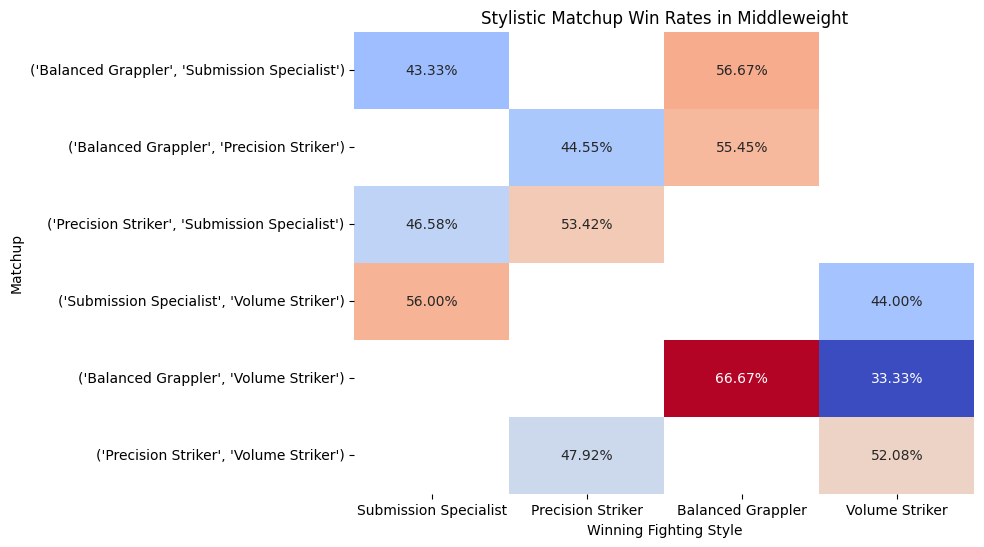

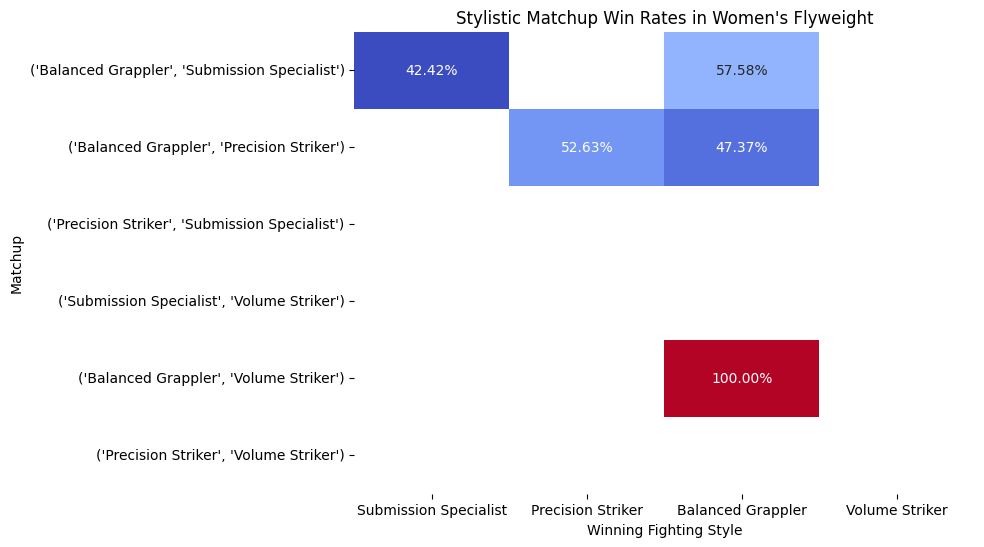

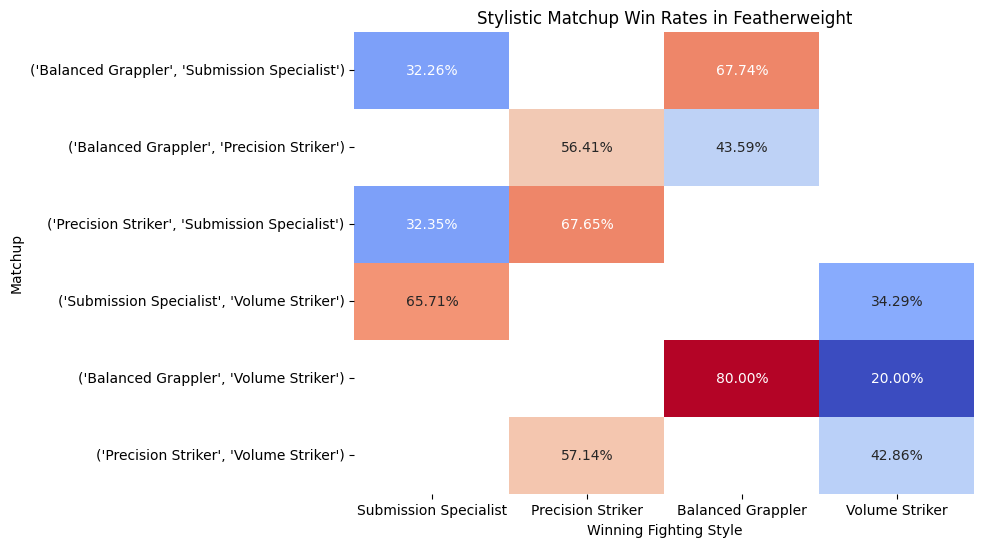

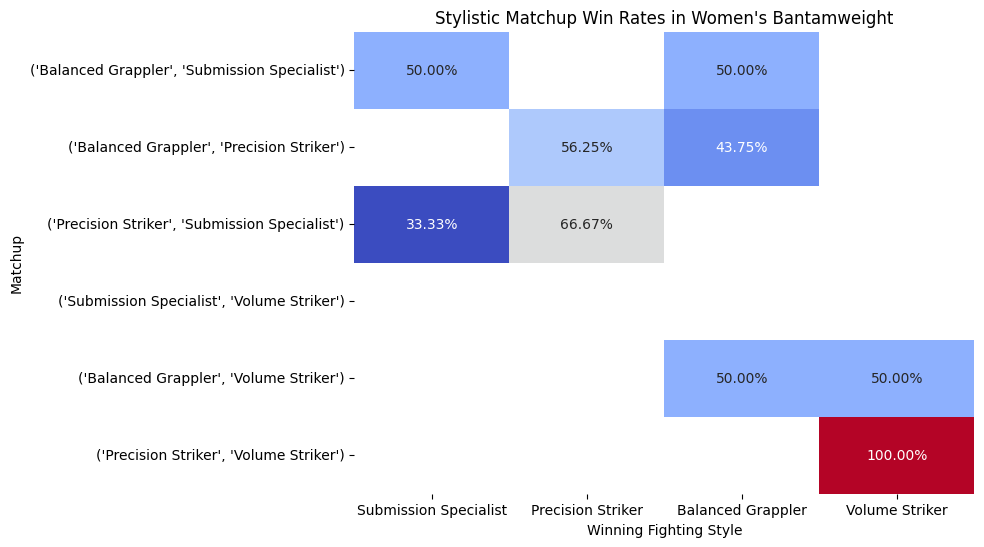

In [68]:
# Get unique weight classes
weight_classes = ufc_filtered_clean['WeightClass'].unique()

# Get all possible matchups & winning styles
all_matchups = ufc_filtered_clean['Matchup'].unique()
all_styles = ufc_filtered_clean['Winning_FightingStyle'].unique()

for weight_class in weight_classes:
    # Filter by weight class
    weight_class_df = ufc_filtered_clean[ufc_filtered_clean['WeightClass'] == weight_class]

    # Compute stylistic matchup win rates
    matchup_win_rates = weight_class_df.groupby(['Matchup', 'Winning_FightingStyle']).size().unstack(fill_value=0)

    # Normalize win rates to percentages
    matchup_win_rates = matchup_win_rates.div(matchup_win_rates.sum(axis=1), axis=0)

    # Ensure all matchups are present, filling missing ones with 0
    matchup_win_rates = matchup_win_rates.reindex(index=all_matchups, columns=all_styles, fill_value=0)

    # Drop redundant rows
    matchup_win_rates_fixed = matchup_win_rates.drop(rows_to_drop, axis=0, errors='ignore')  # Avoids errors if row doesn't exist

    # Generate heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        matchup_win_rates_fixed, 
        cmap="coolwarm", 
        cbar=False, 
        annot=True, 
        fmt=".2%",  # Format as percentage
        mask=(matchup_win_rates_fixed == 0)  # Exclude zeros from colormap
    )

    plt.title(f"Stylistic Matchup Win Rates in {weight_class}")
    plt.xlabel("Winning Fighting Style")
    plt.ylabel("Matchup")

    # Show plot for each weight class
    plt.show()

## Recap

This project systematically analyzed fighter characteristics, fight outcomes, and stylistic matchups using a robust workflow that included Exploratory Data Analysis (EDA), data cleaning, feature engineering, clustering, and matchup analysis. It seems the clustering method which produced the best Sillouhette score was KMeans. One of the clusters ,'Volume Stiker', had a negative win rate across the board against other fighting types. Conversely, 'Balanced Grappler', had the overall highest winrate across our data. This may be due to the fact that 

## [](http://)Future Work
Key stats missing:
* Take Downs Defended (Failed Takedown Opponent Attempts)
* Control Time
* Non-UFC fight stats
* Fix incorrect Fighter records and stats
* Much richer datasets available from sourced like ESPN
* Includes breakdown by strike placement

Future work to scrape ESPN MMA Stats for a much more rich and detailed fight dataset. Given the 